# Asynchronous Advantage Actor-Critic (A3C) Algorithm


A3C operates on the principle of parallelism, where multiple agents explore different parts of the environment simultaneously, each in separate instances of the environment. This approach not only speeds up the training process but also diversifies the experience, reducing the correlation between the data samples and improving the robustness of the policy learned.

The core concept of A3C involves each agent (or "worker") maintaining its own set of neural network parameters while interacting with the environment. These workers asynchronously update a global set of parameters. The "actor" in A3C refers to the policy network that decides which action to take given a state, and the "critic" evaluates the taken action by estimating the value function of the state. The advantage function, which guides the policy update, is calculated as the difference between the predicted value of the action taken and the value predicted by the critic. This decouples the problem of choosing actions and evaluating them, allowing more stable and efficient learning.


## Key Features of A3C

1. **Asynchronous Architecture**: 
   - Multiple agents in parallel environments interact and learn independently. This parallelism allows for efficient learning and exploration.
   - Asynchronous updates help in decorrelating the experiences which typically leads to more stable and robust policy and value function updates.

2. **Actor-Critic Framework**:
   - The actor updates the policy distribution in the direction suggested by the critic’s value function.
   - The critic evaluates the action taken by the actor by computing the value function.

3. **Advantage Function**:
   - The difference between the value function of the current state-action pair and the value function of the current state is used, known as the advantage function. This helps in reducing the variance of the updates.

4. **Entropy Term**:
   - To encourage exploration, A3C adds an entropy bonus to the loss function. This promotes the policy to explore by discouraging premature convergence to suboptimal deterministic policies.

## How A3C Works

The following steps outline the operation of the A3C algorithm:

### Initialization
- Initialize global network weights for both actor and critic networks.
- Spawn multiple agent threads, each with its own set of network weights and environment.

### Parallel Agent Execution
- Each agent interacts with its environment independently.
- Agents collect a set of transitions by following the current policy derived from their local copy of the network.

### Gradient Calculation and Update
- After a certain number of steps or an episode end, each agent calculates gradients to update:
  - The policy (actor) using the policy gradient method.
  - The value function (critic) based on temporal-difference errors.

#### Policy Gradient Calculation
- The policy gradient is calculated using the advantage:
  $$
  \nabla_{\theta^\pi} \log \pi(a_t | s_t; \theta^\pi) A(s_t, a_t)
  $$
  where $A(s_t, a_t) = r_t + \gamma V(s_{t+1}; \theta^v) - V(s_t; \theta^v)$.

#### Value Function Update
- The value function is updated by minimizing the squared-error loss between the estimated value and the computed returns:
  $$
  L = (R_t - V(s_t; \theta^v))^2
  $$

### Asynchronous Update
- Each agent asynchronously updates the global network using its calculated gradients.
- After updating, agents synchronize their local network weights with the updated global weights.

### Exploration and Entropy Bonus
- Exploration is encouraged through stochastic policy outputs and an entropy bonus added to the objective function:
  $$
  H = -\sum \pi(a|s; \theta^\pi) \log \pi(a|s; \theta^\pi)
  $$

## Conclusion
A3C's ability to learn diverse strategies through asynchronous updates and parallel environment interactions makes it a powerful algorithm for complex decision-making tasks in continuous and large discrete action spaces. The incorporation of the advantage function and entropy term helps in stabilizing the learning process and encourages exploration.


## Pseudocode
```
Initialize global network weights θ for actor and ω for critic
Initialize thread-specific network weights θ' and ω' for each worker
Initialize global counter T = 0
Initialize target for global updates T_max

for each worker asynchronously do:
    Initialize gradient dθ and dω to zero
    Initialize thread step counter t = 1
    Get initial state s
    
    while T < T_max do:
        t_start = t
        Initialize t_grad to zero
        Repeat until terminal state or t - t_start == t_max:
            Perform action a_t according to policy π(a_t|s_t;θ')
            Receive reward r_t and new state s_(t+1)
            t_grad = t_grad + 1
            t = t + 1
            T = T + 1
        
        Set R = 0
        if s_t is not terminal then
            R = V(s_t; ω')
        
        for i in {t-1, ..., t_start} do:
            R = r_i + γ * R
            Accumulate gradients wrt θ': dθ += ∇_θ' log π(a_i|s_i;θ') (R - V(s_i;ω'))
            Accumulate gradients wrt ω': dω += ∇_ω' (R - V(s_i;ω'))^2
        
        Perform asynchronous update of θ using dθ and of ω using dω
        Reset gradients dθ, dω to zero
        Update thread-specific parameters θ', ω' from global θ, ω

```

## Import packages

In [1]:
import gym
import pickle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
# from keras import layers, initializers, regularizers
import numpy as np
import threading
from functools import reduce
import time
import os
from collections import deque
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/venv/lib/python3.8/site-packages/tensorflow/python/pywrap_tensorflow_internal.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/venv/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/venv/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by its

Instructions for updating:
non-resource variables are not supported in the long term


/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/venv/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:572: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.object, string),
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/venv/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:573: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.bool,

## util to save checkpoints

In [2]:
# Creates Folder to Store models variables
checkpoint_path = "./models_checkpoints"
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


class StateTrasitionRecorder:

    def __init__(self):
        self.recorder_memory = deque()

    def save_state_transition(self, transition):
        """Save transition
        Inputs:
        trasition - list [s, a, r, s', done]"""

        self.recorder_memory.append(transition)

    def flush_recorder_memory(self):
        self.recorder_memory = deque()

In [3]:
class RolloutBuffer(StateTrasitionRecorder):

    def __init__(self, policy_net_args):
        super().__init__()
        """
        rollout_memory -- deque object, that stores other deque objects that represent episodes: 
        deque([deque_1 ([(state transition 1, state transition 2)]), deque_2([...])])
        """
        self.rollout_memory = deque()
        self.gamma = policy_net_args["gamma"]

    def save_rollout(self, episode):
        """ Saves rollout, computes Qsa and flushs the state transition memory of the current episode 

        Inputs:
        episode --  deque object which contains list of state transitions
        """

        complete_episode = self.compute_total_rewards(episode, self.gamma)
        # print(complete_episode)
        self.rollout_memory.append(complete_episode)
        self.flush_recorder_memory()

    def compute_total_rewards(self, episode_transitions, gamma):
        """ Computes Qsa discounted by gamma values for every state transition of the episode (Rollout)
        Inputs:
        episode --  deque object which contains list of state transitions deque([state transition1], [state transition2])

        Outputs:

        episode-- deque object where each state transition tuple has a new element Qsa : deque([(state transition 1, Qsa1), (state transition 1, Qsa2)])
        """

        states, actions, rewards, nex_states, dones = zip(*episode_transitions)
        Q_s_a = []

        # computationaly intensive operation O(n^2)
        for i in range(len(rewards)):
            Q_i = 0
            for j in range(i, len(rewards)):
                Q_i += rewards[j] * self.gamma ** (j - i)

            Q_s_a.append(Q_i)

        episode = deque(zip(states, actions, rewards,
                            nex_states, dones, Q_s_a))

        return(episode)

    def unroll_state_transitions(self):
        """
        unrroll state transitions for training value function estimator

        Outputs:
        states -- an array of states shape (sum of all state transitions over every rollout in memory , state_space)
        actions -- an array of actions with shape (||, action_space)
        next_states --an array of next_states shape (sum of all state transitions over every rollout in memory , state_space)
        rewards --an array of rewards shape (sum of all state transitions over every rollout in memory , 1)
        dones --  and array of dones shape (sum of all state transitions over every rollout in memory , 1)
        Q(s, a)-- and array of Q(s, a) shape (sum of all state transitions over every rollout in memory , 1)

        """

        states = ()
        actions = ()
        next_states = ()
        rewards = ()
        dones = ()
        Q_sa = ()

        for episode in self.rollout_memory:
            ep_states, ep_actions, ep_next_states, ep_rewards, ep_dones, ep_Q_s_a = zip(
                *episode)

            states += ep_states
            actions += ep_actions
            next_states += ep_next_states
            rewards += ep_rewards
            dones += ep_dones
            Q_sa += ep_Q_s_a

        states = np.asarray(states)
        actions = np.asarray(actions)
        next_states = np.asarray(next_states)
        rewards = np.asarray(rewards)
        dones = np.asarray(dones, dtype=int)
        Q_sa = np.asarray(Q_sa).reshape(-1, 1)

        return states, actions, next_states, rewards, dones, Q_sa

    def flush_rollout_memory(self):
        """Deletes memory of rollouts : to be performed after a step of gradient descent"""

        self.rollout_memory = deque()


## Actor, Critic, Agent models

In [4]:
def build_networks(network_name, num_Hlayers, activations_Hlayers, Hlayer_sizes, n_output_units, output_layer_activation, regularization_constant, network_type, input_features,):
    """
    Creates network and performs forward propagation

    Inputs:
    network_name-- string that will be used in the tensor flow graph as the name of the ANN
    num_Hlayers -- scalar, input layer not included

    input_features -- tensor_flow placeholder: will contain the training examples to fed into the ANN
    Hlayer_sizes -- list with the size of each hidden layer
    activations_Hlayers -- list with the name of the activation function for each hidden layer
    Hlayer_sizes -- list with size of each hidden layer
    n_output_units -- scalar
    output_layer_activation -- activation object for output layer
    network_type -- string , Actor or Critic are the parameters accepted 

    Outputs:
    if network_type == "Actor"
        mu-- tensor with the averages values for the actions at a given state
        covariance -- tensor with the values for the covariance matrix
        params -- list with tf.Variable objects created in the network: weights and biases

    if network_type == "Critic"
        critic-- tensor with the expected reward for a given state
        params -- list with tf.Variable objects created in the network: weights and biases
    """

    assert(num_Hlayers == (len(activations_Hlayers)) and num_Hlayers ==
           len(Hlayer_sizes)),  "Check the number of activations and layer_sizes provided "

    with tf.variable_scope(network_type):

        network = tf.layers.Dense(Hlayer_sizes[0], activation=activations_Hlayers[0], kernel_initializer=tf.keras.initializers.glorot_normal(),
                                  kernel_regularizer=tf.keras.regularizers.l2(regularization_constant), name="Layer_1")(input_features)

        for layer in range(1, num_Hlayers):

            network = tf.layers.Dense(units=Hlayer_sizes[layer], kernel_initializer=tf.keras.initializers.glorot_normal(), kernel_regularizer=tf.keras.regularizers.l2(regularization_constant), activation=activations_Hlayers[layer], name=(
                "Layer_" + str(layer + 1)))(network)

        if network_type == "Actor":
            mu = tf.layers.Dense(units=n_output_units, kernel_initializer=tf.initializers.glorot_normal(),
                                 kernel_regularizer=tf.keras.regularizers.l2(regularization_constant), activation=output_layer_activation, name="mu")(network)

            covariance = tf.layers.Dense(
                units=n_output_units, kernel_initializer=tf.initializers.glorot_normal(), kernel_regularizer=tf.keras.regularizers.l2(regularization_constant), activation=tf.nn.softplus, name="covariance")(network)
            # finds the parameters for the covariance matrix

            # params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=network_type)

            params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, network_name + "/" + network_type)

            return mu, covariance, params

        else:

            critic = tf.layers.Dense(units=n_output_units, kernel_initializer=tf.initializers.glorot_normal(
            ), activation=output_layer_activation, kernel_regularizer=tf.keras.regularizers.l2(regularization_constant), name="V")(network)
            # params = tf.trainable_variables(scope=network_name + "/" + network_type)
            params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, network_name + "/" + network_type)

            return critic, params

In [5]:
all_actor_losses = []
all_critic_losses = []

In [6]:
class ComputationGraph:
    """ Creates the main components of the graph: Creates operation for the optimization of both actor and critic networks"""

    def __init__(self, name, policy_network_args, value_function_network_args):
        """
        Inputs : 
        name -- string with the name of the Agent the created graph will belong to  
        policy_network_args -- dictionary of parameters needed to train the Actor network
        value_function_network_args -- dictionary of parameters needed to train the Critic network 
        """
        super().__init__(policy_network_args)

        with tf.variable_scope(name):
            self.actor_optimizer = policy_network_args["optimizer"]
            self.critic_optimizer = value_function_network_args["optimizer"]

            self.st_placeholder = tf.placeholder(dtype=tf.float32, shape=[
                None, policy_network_args["state_space_size"]], name="State")

            self.rewards_placeholder = tf.placeholder(
                tf.float32, shape=[None, 1], name="rewards")
            self.actions_placeholder = tf.placeholder(
                tf.float32, shape=[None, policy_network_args["action_space_size"]], name="actions")
            self.dones_placeholder = tf.placeholder(
                tf.float32, shape=[None, 1], name="dones")

            self.Qsa_placeholder = tf.placeholder(
                dtype=tf.float32, shape=[None, 1], name="Q_sa")

            self.mu, self.covariance, self.actor_params = build_networks(name, policy_network_args["num_Hlayers"], policy_network_args["activations_Hlayers"], policy_network_args[
                "Hlayer_sizes"], policy_network_args["n_output_units"], policy_network_args["output_layer_activation"], policy_network_args["regularization_constant"], "Actor", self.st_placeholder)

            self.critic, self.critic_params = build_networks(name, value_function_network_args["num_Hlayers"], value_function_network_args["activations_Hlayers"], value_function_network_args[
                "Hlayer_sizes"], value_function_network_args["n_output_units"], value_function_network_args["output_layer_activation"], value_function_network_args["regularization_constant"], "Critic", self.st_placeholder)

            with tf.variable_scope("Train_value_function_estimator"):

                self.value_function_net_cost = tf.losses.mean_squared_error(
                    self.Qsa_placeholder, self.critic) + tf.losses.get_regularization_loss(scope=name + "/" + "Critic")

                tf.summary.scalar("Critic_Cost", self.value_function_net_cost)

                # self.value_function_net_opt = tf.train.AdamOptimizer().minimize(
                #     self.value_function_net_cost, var_list=self.critic_params)

            if name == "Global_Agent":

                # get summary for Global Agent

                for variable in self.actor_params:
                    var_name = "Actor_" + variable.name.replace("kernel:0", "w").replace("bias:0", "b")
                    tf.summary.histogram(var_name, variable)

                for variable in self.critic_params:
                    var_name = "Critic_" + variable.name.replace("kernel:0", "w").replace("bias:0", "b")
                    tf.summary.histogram(var_name, variable)

            with tf.variable_scope("Train_policy_network"):

                self.advantage_funtion = tf.math.subtract(
                    self.Qsa_placeholder, self.critic)

                # Find the pdf
                self.probability_density_func = tf.distributions.Normal(
                    self.mu, self.covariance)

                self.log_prob_a = self.probability_density_func.log_prob(
                    self.actions_placeholder)

                auxiliary = tf.multiply(
                    self.log_prob_a, self.advantage_funtion)

                entropy = self.probability_density_func.entropy()

                self.auxiliary = policy_network_args["Entropy"] * \
                    entropy + auxiliary

                self.policy_net_cost = tf.reduce_sum(-self.auxiliary) + tf.losses.get_regularization_loss(scope=name + "/" + "Actor")

                # Store policy cost
                self.summary_policy_cost = tf.summary.scalar("Policy_Cost", self.policy_net_cost)

            with tf.name_scope("choose_a"):

                self.action = tf.clip_by_value(self.probability_density_func.sample(
                    1), policy_network_args["action_space_lower_bound"], policy_network_args["action_space_upper_bound"])

            with tf.name_scope("get_grad"):
                self.actor_grads = tf.gradients(self.policy_net_cost, self.actor_params)
                self.critic_grads = tf.gradients(self.value_function_net_cost, self.critic_params)
                
                all_actor_losses.append(self.policy_net_cost)
                all_critic_losses.append(self.value_function_net_cost)

                # Save information to examine the gradients for problems like vanishing or exploding gradients

                for act_grad, critic_grad in zip(self.actor_grads, self.critic_grads):
                    var_name_actor = "Actor_" + act_grad.name.replace("Addn", "w")
                    var_name_critic = "Critic_" + critic_grad.name.replace("Addn", "w")
                    tf.summary.histogram(var_name_actor, act_grad)
                    tf.summary.histogram(var_name_critic, critic_grad)

            self.summaries = tf.summary.merge_all()



In [7]:

class RLAgent(ComputationGraph, RolloutBuffer):

    """Creates the backbone of every RL Agent
    An Agent in A3C will operate individually, but be a part of system of Agents all connected to a Global agent, to which all child agents will periodically syncronize with. 
    """

    def __init__(self, name,  policy_network_args, value_function_network_args, session, summary_writer, Global_Agent=None):
        """Inputs: 
           name --  string with the name of the Agent the created graph will belong to  
           session -- a tensorflow session every operation will be run in 
           summary_writer -- FileWriter object that will save summaries to then be presented in Tensorboard
           Global_Agent -- A Global_Agent object, which is very similar to a simple RL Agent but with some 
           specific methods for keep track of the improvement of the overall group of child agents

        """
        super().__init__(name, policy_network_args, value_function_network_args)

        self.current_num_epi = 0
        self.env = gym.make('LunarLanderContinuous-v2')
        self.total_number_episodes = policy_network_args["total_number_episodes"]
        self.num_episodes_before_update = policy_network_args["number_of_episodes_before_update"]
        self.Global_Agent = Global_Agent
        self.ep_rewards = []
        self.trajectory_lengths = []
        self.frequency_printing_statistics = policy_network_args["frequency_of_printing_statistics"]
        self.episodes_back = policy_network_args["episodes_back"]
        self.rendering_frequency = policy_network_args["frequency_of_rendering_episode"]
        self.max_steps = policy_network_args["max_steps_per_episode"]
        self.summary_writer = summary_writer
        self.name = name

        self.session = session
        if Global_Agent is not None:
            with tf.name_scope(name):

                with tf.name_scope('sync'):  # update global network and local network
                    with tf.name_scope('pull_from_global'):
                        self.pull_actor_params_op = [local_params.assign(
                            global_params) for local_params, global_params in zip(self.actor_params, Global_Agent.actor_params)]
                        self.pull_critic_params_op = [local_params.assign(
                            global_params) for local_params, global_params in zip(self.critic_params, Global_Agent.critic_params)]
                    with tf.name_scope("push_to_global"):
                        self.push_actor_params_op = self.actor_optimizer.apply_gradients(zip(self.actor_grads, self.Global_Agent.actor_params))
                        self.push_critic_params_op = self.critic_optimizer.apply_gradients(zip(self.critic_grads, Global_Agent.critic_params))

    def update_Global_Agent(self, feed_dict):
        """updates the Global Agent with the parameters find locally by running gradient descent"""
        _, _, = self.session.run([self.push_actor_params_op,
                                  self.push_critic_params_op], feed_dict)

    def save_summary(self, feed_dict):
        """Collects summary operations and writes with the FileWriter"""
        summary = self.session.run(self.Global_Agent.summaries, feed_dict)
        self.summary_writer.add_summary(summary, self.Global_Agent.current_num_epi)

    def pull_from_global(self):
        """ Updates the parameters of the local networks with the parameters coming from the Global network
            Because the Global Network suffers asychronous updates from variuous child agents we need to pull from Global to 
            provide all the childs with the information gained from other child agents as the only link between them is the Global network """
        self.session.run([self.pull_actor_params_op,
                          self.pull_critic_params_op])

    def take_action(self, state):
        """Computes the action to take at a given state s 
        Input:
        state-- an array with shape (state_space_size,)
        Returns:
        action -- an array with with schape (action_space)


        """
        state = state.reshape(-1, 8)
        # v = self.session.run([self.critic], feed_dict={self.st_placeholder: state})
        # print(f"Expected Reward {v}")
        # mu = self.session.run([self.mu], feed_dict={self.st_placeholder: state})
        # covariance = self.session.run([self.covariance], feed_dict={self.st_placeholder: state})
        # print(f"Mean {mu} \n")
        # print(f"Covariance {covariance} \n")

        action = self.session.run([self.action], feed_dict={
                                  self.st_placeholder: state})
        # print(action)

        return action[0].reshape(2,)

    def collect_rollouts(self, n_rolls, max_steps, render=False):
        """ Runs a specified number of episodes and collects the sate transition information

        Inputs:
        n_rolls -- int number of episodes to run 
        max_steps -- maximum number of decisions allowed per episode
        prevents the episode of never ending, which can happen, if the agent never crashes nor lands 
        render-- boolean: True if we want to render the episode, False otherwise
        """
        for i in range(n_rolls):
            n_steps = 0
            state = self.env.reset()
            done = False
            sum_rewards = 0
            while not done and n_steps <= max_steps:
                if render:
                    self.env.render()

                action = self.take_action(state)
                # print(action)
                next_state, reward, done, info = self.env.step(action)

                if not done and n_steps == max_steps:
                    # print("here")
                    state_feed = next_state.reshape(-1, 8)
                    reward = reward + float(self.session.run([self.critic], feed_dict={self.st_placeholder: state_feed})[0])

                self.save_state_transition(
                    [state, action, reward, next_state, done])

                # print(f"""Observation: {next_state.shape} \n
                #         Reward:  {reward} \n
                #         Done: {done}
                #         """)

                sum_rewards += reward
                state = next_state
                n_steps += 1

            if self.name == "Global_Agent":
                print(f"Episode Reward: {sum_rewards}")

            self.ep_rewards.append(sum_rewards)
            self.trajectory_lengths.append(n_steps)
            self.save_rollout(self.recorder_memory)

    def training_loop(self):
        """Runs episodes in a loop and performs steps of gradient descent after every episode"""

        while not coord.should_stop() and self.Global_Agent.current_num_epi <= self.total_number_episodes:
            self.collect_rollouts(
                self.num_episodes_before_update, self.max_steps, render=False)

            states, actions, next_states, rewards, dones, Q_sa = self.unroll_state_transitions()

            feed_dict = {self.st_placeholder: states,
                         self.actions_placeholder: actions,
                         self.Qsa_placeholder: Q_sa}

            self.update_Global_Agent(feed_dict)
            self.Global_Agent.current_num_epi += self.num_episodes_before_update

            feed_dict_global_summary = {self.Global_Agent.st_placeholder: states,
                                        self.Global_Agent.actions_placeholder: actions,
                                        self.Global_Agent.Qsa_placeholder: Q_sa}

            self.save_summary(feed_dict_global_summary)

            self.flush_rollout_memory()
            self.pull_from_global()

            if self.Global_Agent.current_num_epi % self.frequency_printing_statistics == 0:

                average_reward = self.Global_Agent.compute_average_rewards(self.episodes_back)
                print(
                    f"Global ep number {self.Global_Agent.current_num_epi}: Reward = {average_reward}")

            # if self.Global_Agent.current_num_epi % self.rendering_frequency == 0:
            #     self.Global_Agent.collect_rollouts(1, render=True)


In [8]:
class Global_Agent(RLAgent):
    def __init__(self, name, policy_network_args, value_function_network_args, session, summary_writer, child_agents=[]):
        super().__init__(name, policy_network_args, value_function_network_args, session, summary_writer)
        self.child_agents = child_agents
        self.num_childs = len(child_agents)

    def compute_average_rewards(self, episodes_back):
        """Computes the average reward of each child agent going n episodes back, and returnes the average of those average rewards"""
        reward = 0
        for agent in self.child_agents:
            agent_average_reward = reduce(
                lambda x, y: x + y, agent.ep_rewards[-episodes_back:]) / episodes_back
            reward += agent_average_reward

        reward /= self.num_childs

        return reward

## Main runner

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/venv/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/venv/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/venv/lib/python3.8/site-packages/tensorflow/python/ops/variable_scope.py:453: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 

INFO:tensorflow:Summary name Actor_Global_Agent/get_grad/gradients/AddN_5:0 is illegal; using Actor_Global_Agent/get_grad/gradients/AddN_5_0 instead.
INFO:tensorflow:Summary name Critic_Global_Agent/get_grad/gradients_1/AddN_2:0 is illegal; using Critic_Global_Agent/get_grad/gradients_1/AddN_2_0 instead.
INFO:tensorflow:Summary name Actor_Global_Agent/get_grad/gradients/Global_Agent/Actor/Layer_1/BiasAdd_grad/BiasAddGrad:0 is illegal; using Actor_Global_Agent/get_grad/gradients/Global_Agent/Actor/Layer_1/BiasAdd_grad/BiasAddGrad_0 instead.
INFO:tensorflow:Summary name Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_1/BiasAdd_grad/BiasAddGrad:0 is illegal; using Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_1/BiasAdd_grad/BiasAddGrad_0 instead.
INFO:tensorflow:Summary name Actor_Global_Agent/get_grad/gradients/AddN_4:0 is illegal; using Actor_Global_Agent/get_grad/gradients/AddN_4_0 instead.
INFO:tensorflow:Summary name Critic_Global_Agent/get_gra

INFO:tensorflow:Summary name Actor_ChildAgent_2/get_grad/gradients/AddN_4:0 is illegal; using Actor_ChildAgent_2/get_grad/gradients/AddN_4_0 instead.
INFO:tensorflow:Summary name Critic_ChildAgent_2/get_grad/gradients_1/AddN_1:0 is illegal; using Critic_ChildAgent_2/get_grad/gradients_1/AddN_1_0 instead.
INFO:tensorflow:Summary name Actor_ChildAgent_2/get_grad/gradients/ChildAgent_2/Actor/Layer_2/BiasAdd_grad/BiasAddGrad:0 is illegal; using Actor_ChildAgent_2/get_grad/gradients/ChildAgent_2/Actor/Layer_2/BiasAdd_grad/BiasAddGrad_0 instead.
INFO:tensorflow:Summary name Critic_ChildAgent_2/get_grad/gradients_1/ChildAgent_2/Critic/Layer_2/BiasAdd_grad/BiasAddGrad:0 is illegal; using Critic_ChildAgent_2/get_grad/gradients_1/ChildAgent_2/Critic/Layer_2/BiasAdd_grad/BiasAddGrad_0 instead.
INFO:tensorflow:Summary name Actor_ChildAgent_2/get_grad/gradients/AddN_3:0 is illegal; using Actor_ChildAgent_2/get_grad/gradients/AddN_3_0 instead.
INFO:tensorflow:Summary name Critic_ChildAgent_2/get_gra

INFO:tensorflow:Summary name Critic_ChildAgent_5/get_grad/gradients_1/ChildAgent_5/Critic/V/BiasAdd_grad/BiasAddGrad:0 is illegal; using Critic_ChildAgent_5/get_grad/gradients_1/ChildAgent_5/Critic/V/BiasAdd_grad/BiasAddGrad_0 instead.
INFO:tensorflow:Summary name Actor_ChildAgent_6/get_grad/gradients/AddN_5:0 is illegal; using Actor_ChildAgent_6/get_grad/gradients/AddN_5_0 instead.
INFO:tensorflow:Summary name Critic_ChildAgent_6/get_grad/gradients_1/AddN_2:0 is illegal; using Critic_ChildAgent_6/get_grad/gradients_1/AddN_2_0 instead.
INFO:tensorflow:Summary name Actor_ChildAgent_6/get_grad/gradients/ChildAgent_6/Actor/Layer_1/BiasAdd_grad/BiasAddGrad:0 is illegal; using Actor_ChildAgent_6/get_grad/gradients/ChildAgent_6/Actor/Layer_1/BiasAdd_grad/BiasAddGrad_0 instead.
INFO:tensorflow:Summary name Critic_ChildAgent_6/get_grad/gradients_1/ChildAgent_6/Critic/Layer_1/BiasAdd_grad/BiasAddGrad:0 is illegal; using Critic_ChildAgent_6/get_grad/gradients_1/ChildAgent_6/Critic/Layer_1/BiasAd

Episode Reward: 298.28644546187047
Episode Reward: 308.4886825903783
Episode Reward: 262.24869057829255
Episode Reward: 257.13020818631054
Episode Reward: 230.82775247561517
Episode Reward: 241.31507577357922
Episode Reward: 269.32875772238134
Episode Reward: 290.5096645752376
Episode Reward: -55.25209835386597
Episode Reward: 240.82729043064623
Episode Reward: 218.69525367002882
Episode Reward: -153.62934738774644
Episode Reward: 196.27577455075067
Episode Reward: 288.61296635442477
Episode Reward: 256.8188338967363
Episode Reward: 243.08156008996426
Episode Reward: 158.07219348875714
Episode Reward: 248.04497877183422
Episode Reward: 264.39949028603706
Episode Reward: 254.72371840699117
Episode Reward: 280.0007316406601
Episode Reward: 237.27519831673706
Episode Reward: 267.2825804094131
Episode Reward: -288.9358057791058
Episode Reward: 216.39186374711932
Episode Reward: 216.327657857759
Episode Reward: 238.24021388313773
Episode Reward: 221.7747797258732
Episode Reward: 301.1700186

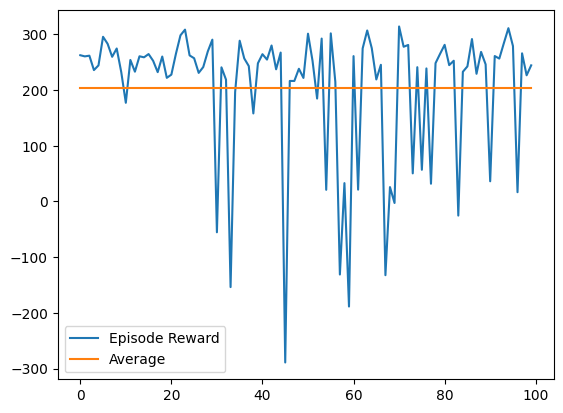

In [9]:
env = gym.make('LunarLanderContinuous-v2')
action_space_upper_bound = env.action_space.high
action_space_lower_bound = env.action_space.low
subdir = time.strftime("%Y%m%d-%H%M%S", time.localtime())
logdir = "./summary/" + subdir
writer = tf.summary.FileWriter(logdir)
sess = tf.Session()

policy_net_args = {"num_Hlayers": 2,
                    "activations_Hlayers": ["relu", "relu"],
                    "Hlayer_sizes": [100, 100],
                    "n_output_units": 2,
                    "output_layer_activation": tf.nn.tanh,
                    "state_space_size": 8,
                    "action_space_size": 2,
                    "Entropy": 0.01,
                    "action_space_upper_bound": action_space_upper_bound,
                    "action_space_lower_bound": action_space_lower_bound,
                    "optimizer": tf.train.RMSPropOptimizer(0.0001),
                    "total_number_episodes": 5000,
                    "number_of_episodes_before_update": 1,
                    "frequency_of_printing_statistics": 100,
                    "frequency_of_rendering_episode": 1000,
                    "number_child_agents": 8,
                    "episodes_back": 20,
                    "gamma": 0.99,
                    "regularization_constant": 0.01,
                    "max_steps_per_episode": 2000

                    }

valuefunction_net_args = {"num_Hlayers": 2,
                            "activations_Hlayers": ["relu", "relu"],
                            "Hlayer_sizes": [100, 64],
                            "n_output_units": 1,
                            "output_layer_activation": "linear",
                            "state_space_size": 8,
                            "action_space_size": 2,
                            "optimizer": tf.train.RMSPropOptimizer(0.01),
                            "regularization_constant": 0.01}

global_agent = Global_Agent("Global_Agent", policy_net_args, valuefunction_net_args, sess, writer)

child_agents = []

for i in range(policy_net_args["number_child_agents"]):
    i_name = f"ChildAgent_{i}"
    child_agents.append(RLAgent(i_name, policy_net_args, valuefunction_net_args, sess, writer, global_agent))

global_agent.child_agents = child_agents
global_agent.num_childs = len(child_agents)

saver = tf.train.Saver()

coord = tf.train.Coordinator()

# Check if there is a model checkpoint, if there is load variables in the model
if len(os.listdir(checkpoint_path)) == 0:

    sess.run(tf.global_variables_initializer())
else:
    saver.restore(sess, checkpoint_path + "/variables.ckpt")

# Creates a saver to hold trained weights

child_agents_threads = []

subdir = time.strftime("%Y%m%d-%H%M%S", time.localtime())
logdir = "./summary/" + subdir
# writer = tf.summary.FileWriter(logdir)
writer.add_graph(sess.graph)

for child_agent in child_agents:
    def job(): return child_agent.training_loop()
    t = threading.Thread(target=job)
    t.start()
    child_agents_threads.append(t)

coord.join(child_agents_threads)
saver.save(sess, checkpoint_path + "/variables.ckpt")


# Test the model at the end of trainning

for i in range(1):

    global_agent.collect_rollouts(10, 2000, render=False)
    global_agent.collect_rollouts(90, 2000)

rewards = global_agent.ep_rewards
average = sum(rewards)/len(rewards)
average = [average] * 100

fig, ax = plt.subplots()

writer.close()

ax.plot(rewards, label="Episode Reward")
ax.plot(average, label="Average")
ax.legend(loc="best")
plt.show()

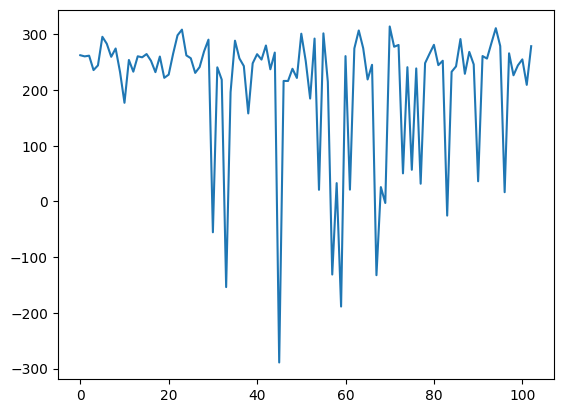

In [70]:
plt.plot(global_agent.ep_rewards)

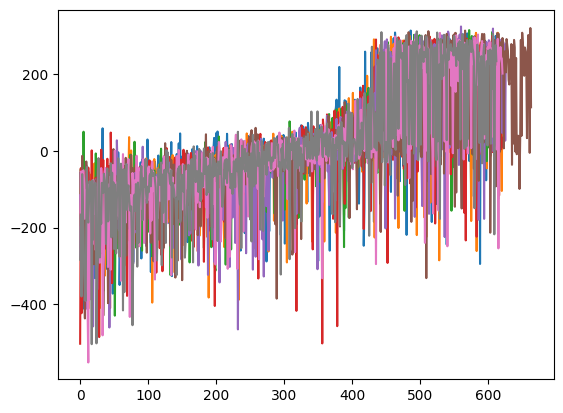

In [67]:
for c in child_agents:
    plt.plot(c.ep_rewards)

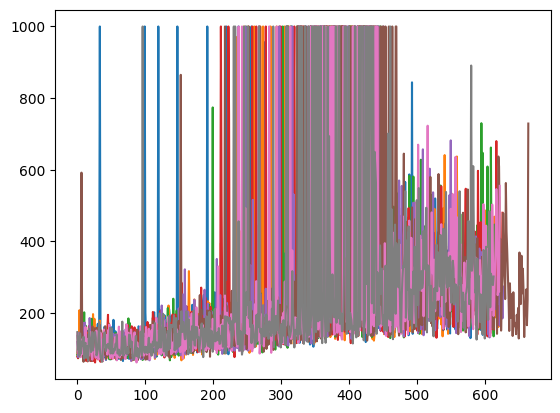

In [12]:
for c in child_agents:
    plt.plot(c.trajectory_lengths)

In [13]:
# print([x.i all_critic_losses])
print(len(all_critic_losses))



9


In [14]:
# print(tf.summary.get_summary_description("events.out.tfevents.1714327784.rafik-Legion-7"))

In [15]:
from tensorflow.python.summary import summary_iterator
import glob
from pathlib import Path
def read_tf_summary(path):
    for e in summary_iterator.summary_iterator(path):
        for v in e.summary.value:
            if 'Critic' in v.tag:
                print('Step:', e.step,'Tag:', v.tag, 'Output:', v.simple_value)

                
for f_path in Path("/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary").rglob('*'):
    try:
        read_tf_summary(str(f_path))
    except Exception as e:
        print(e)
# Path to the TensorFlow events file
log_file = '/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240428-210940/events.out.tfevents.1714327784.rafik-Legion-7'

# read_tf_summary(log_file)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-212348; Is a directory
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-205044; Is a directory
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-211201; Is a directory
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240428-210942; Is a directory
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-205149; Is a directory
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-204855; Is a directory
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-205147; Is a directory
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-204957; Is a directory
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-205042; Is 

Step: 627 Tag: Global_Agent/Train_value_function_estimator/Critic_Cost Output: 306.3953857421875
Step: 627 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/w Output: 0.0
Step: 627 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/b Output: 0.0
Step: 627 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/w Output: 0.0
Step: 627 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/b Output: 0.0
Step: 627 Tag: Global_Agent/Critic_Global_Agent/Critic/V/w Output: 0.0
Step: 627 Tag: Global_Agent/Critic_Global_Agent/Critic/V/b Output: 0.0
Step: 627 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_2_0 Output: 0.0
Step: 627 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_1/BiasAdd_grad/BiasAddGrad_0 Output: 0.0
Step: 627 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_1_0 Output: 0.0
Step: 627 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_2/Bias

Step: 642 Tag: Global_Agent/Train_value_function_estimator/Critic_Cost Output: 422.83135986328125
Step: 642 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/w Output: 0.0
Step: 642 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/b Output: 0.0
Step: 642 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/w Output: 0.0
Step: 642 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/b Output: 0.0
Step: 642 Tag: Global_Agent/Critic_Global_Agent/Critic/V/w Output: 0.0
Step: 642 Tag: Global_Agent/Critic_Global_Agent/Critic/V/b Output: 0.0
Step: 642 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_2_0 Output: 0.0
Step: 642 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_1/BiasAdd_grad/BiasAddGrad_0 Output: 0.0
Step: 642 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_1_0 Output: 0.0
Step: 642 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_2/Bia

Step: 1294 Tag: Global_Agent/Train_value_function_estimator/Critic_Cost Output: 881.5949096679688
Step: 1294 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/w Output: 0.0
Step: 1294 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/b Output: 0.0
Step: 1294 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/w Output: 0.0
Step: 1294 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/b Output: 0.0
Step: 1294 Tag: Global_Agent/Critic_Global_Agent/Critic/V/w Output: 0.0
Step: 1294 Tag: Global_Agent/Critic_Global_Agent/Critic/V/b Output: 0.0
Step: 1294 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_2_0 Output: 0.0
Step: 1294 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_1/BiasAdd_grad/BiasAddGrad_0 Output: 0.0
Step: 1294 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_1_0 Output: 0.0
Step: 1294 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/L

Step: 1309 Tag: Global_Agent/Train_value_function_estimator/Critic_Cost Output: 153.28872680664062
Step: 1309 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/w Output: 0.0
Step: 1309 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/b Output: 0.0
Step: 1309 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/w Output: 0.0
Step: 1309 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/b Output: 0.0
Step: 1309 Tag: Global_Agent/Critic_Global_Agent/Critic/V/w Output: 0.0
Step: 1309 Tag: Global_Agent/Critic_Global_Agent/Critic/V/b Output: 0.0
Step: 1309 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_2_0 Output: 0.0
Step: 1309 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_1/BiasAdd_grad/BiasAddGrad_0 Output: 0.0
Step: 1309 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_1_0 Output: 0.0
Step: 1309 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/

Step: 1988 Tag: Global_Agent/Train_value_function_estimator/Critic_Cost Output: 1454.559814453125
Step: 1988 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/w Output: 0.0
Step: 1988 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_1/b Output: 0.0
Step: 1988 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/w Output: 0.0
Step: 1988 Tag: Global_Agent/Critic_Global_Agent/Critic/Layer_2/b Output: 0.0
Step: 1988 Tag: Global_Agent/Critic_Global_Agent/Critic/V/w Output: 0.0
Step: 1988 Tag: Global_Agent/Critic_Global_Agent/Critic/V/b Output: 0.0
Step: 1988 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_2_0 Output: 0.0
Step: 1988 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/Layer_1/BiasAdd_grad/BiasAddGrad_0 Output: 0.0
Step: 1988 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/AddN_1_0 Output: 0.0
Step: 1988 Tag: Global_Agent/get_grad/Critic_Global_Agent/get_grad/gradients_1/Global_Agent/Critic/L

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
for c in child_agents:
    print(c.summaries)

Tensor("ChildAgent_0/Merge/MergeSummary:0", shape=(), dtype=string)
Tensor("ChildAgent_1/Merge/MergeSummary:0", shape=(), dtype=string)
Tensor("ChildAgent_2/Merge/MergeSummary:0", shape=(), dtype=string)
Tensor("ChildAgent_3/Merge/MergeSummary:0", shape=(), dtype=string)
Tensor("ChildAgent_4/Merge/MergeSummary:0", shape=(), dtype=string)
Tensor("ChildAgent_5/Merge/MergeSummary:0", shape=(), dtype=string)
Tensor("ChildAgent_6/Merge/MergeSummary:0", shape=(), dtype=string)
Tensor("ChildAgent_7/Merge/MergeSummary:0", shape=(), dtype=string)


Episode Reward: 288.7184809705608


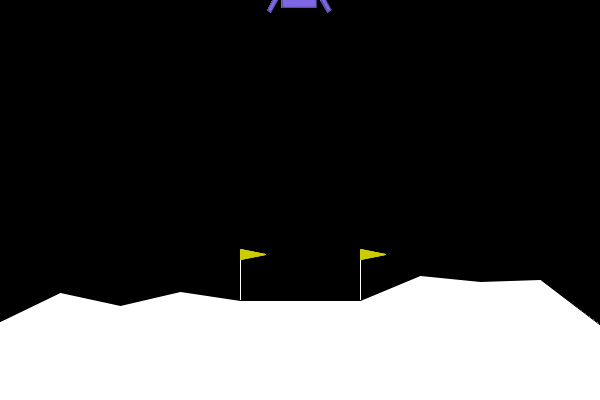

In [65]:
from IPython.display import Image as IImage
from PIL import Image

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    state = env.reset()
    imgs = [np.array(env.render()[0])]
    total = 0
    for n_steps in range(max_steps):
        action = global_agent.take_action(state)
            
        obs, reward, terminated, truncated = env.step(action)
        done = terminated
        total += reward
        render_res  = env.render(mode="rgb_array")
        
        
#         print(render_res[0])
        imgs.append(np.array(render_res[0]))
    
        if not done and n_steps == max_steps:
            # print("here")
            state_feed = next_state.reshape(-1, 8)
            reward = reward + float(global_agent.session.run([global_agent.critic], feed_dict={global_agent.st_placeholder: state_feed})[0])

            global_agent.save_state_transition(
                    [state, action, reward, next_state, done])
        
        if terminated or truncated:
            break
    print(total)

    return imgs

def rendered_rollout(self, env):
    n_steps = 0
    state = env.reset()
    imgs = [np.array(env.render()[0])]
    done = False
    sum_rewards = 0
    max_steps = 10000
    while not done and n_steps <= max_steps:
#         if render:
#             self.env.render()

        action = self.take_action(state)
        # print(action)
        next_state, reward, done, info = env.step(action)
        
        render_res  = env.render(mode="rgb_array")
        
        
#         print(render_res[0])
        imgs.append(np.array(render_res[0]))

        if not done and n_steps == max_steps:
            # print("here")
            state_feed = next_state.reshape(-1, 8)
            reward = reward + float(self.session.run([self.critic], feed_dict={self.st_placeholder: state_feed})[0])

        self.save_state_transition(
            [state, action, reward, next_state, done])

        # print(f"""Observation: {next_state.shape} \n
        #         Reward:  {reward} \n
        #         Done: {done}
        #         """)

        sum_rewards += reward
        state = next_state
        n_steps += 1

    if self.name == "Global_Agent":
        print(f"Episode Reward: {sum_rewards}")
    return imgs
env = gym.make('LunarLanderContinuous-v2', render_mode="rgb_array")

imgs = rendered_rollout(global_agent, env)
# print(imgs)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

In [51]:
global_agent.collect_rollouts(1, 2000, render=True)

Episode Reward: 278.7478172085303


617


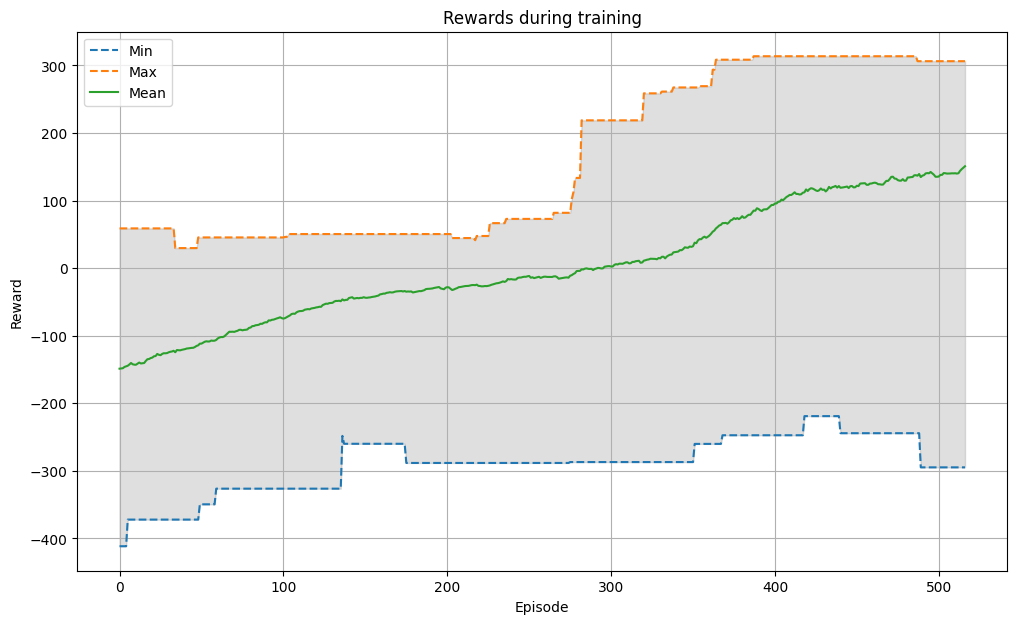

In [77]:
all_rewards = child_agents[0].ep_rewards

print(len(all_rewards))

interval = 100
min_r = [min(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)]
max_r = [max(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)]
plt.figure(figsize=(12, 7))
plt.plot(min_r, label="Min", linestyle='--')
plt.plot(max_r, label="Max", linestyle='--')
plt.plot([np.mean(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)], label="Mean")
plt.legend()
plt.fill_between(range(len(all_rewards)-interval), min_r, max_r, color='gray', alpha=0.25)
plt.title("Rewards during training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig('aggregated_rewards.png')

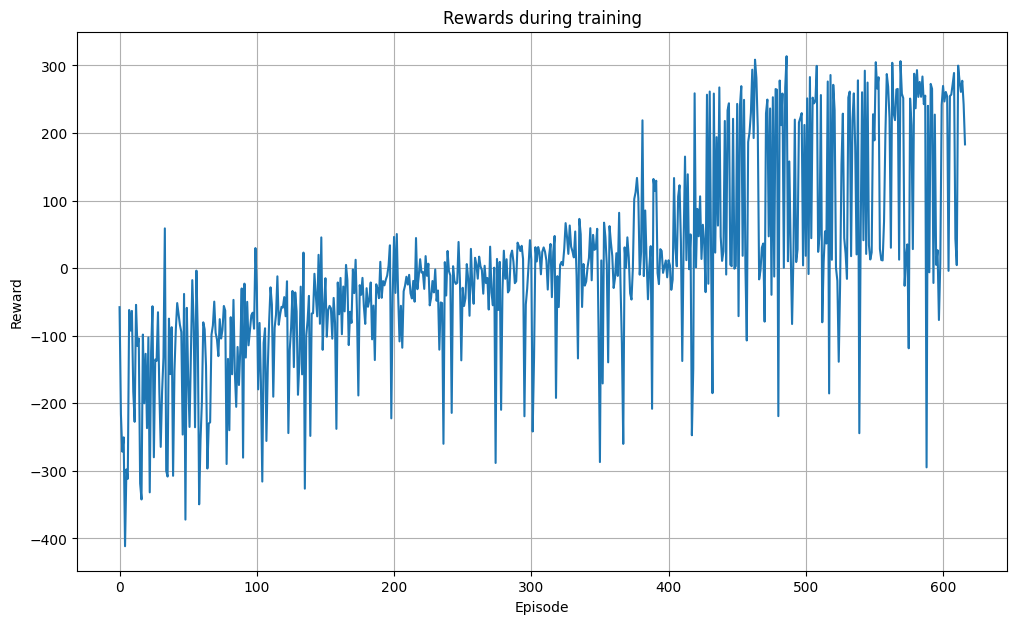

In [73]:
plt.figure(figsize=(12, 7))
plt.plot(all_rewards)
plt.title("Rewards during training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig("single_rewards.png")

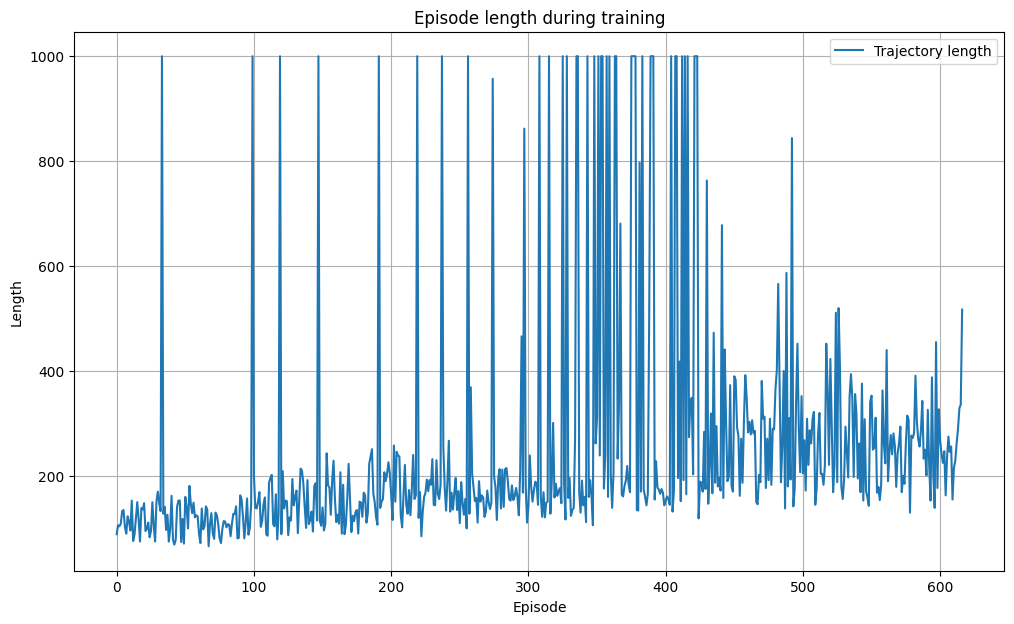

In [74]:
all_trajectory_lengths = child_agents[0].trajectory_lengths

plt.figure(figsize=(12, 7))
plt.plot(all_trajectory_lengths, label="Trajectory length")
plt.legend()
plt.title("Episode length during training")
plt.xlabel("Episode")
plt.ylabel("Length")
plt.grid()
plt.savefig("episode_length.png")

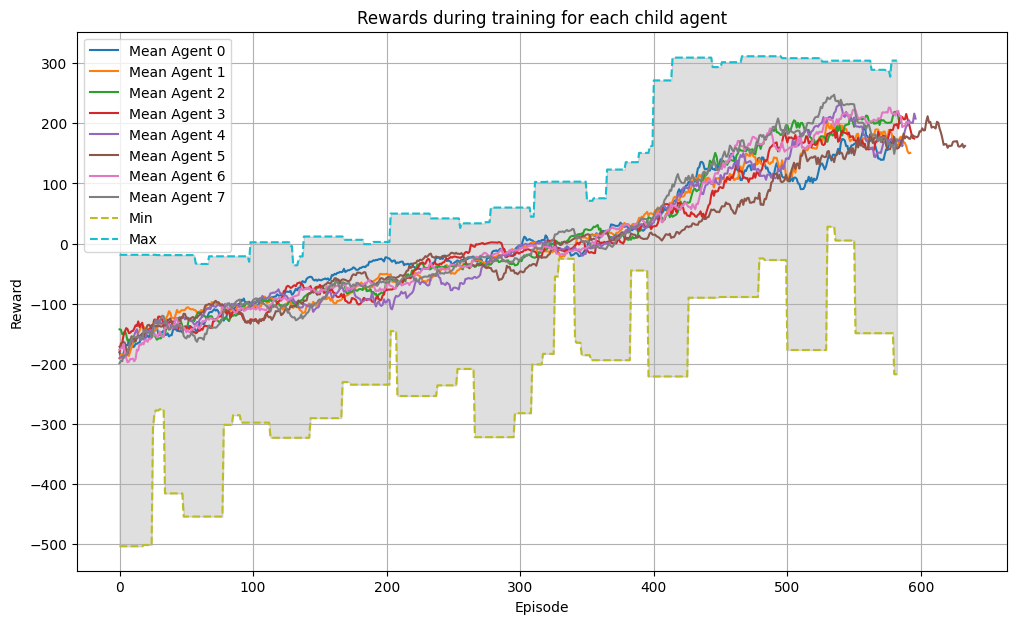

In [76]:
plt.figure(figsize=(12, 7))

for i, c in enumerate(child_agents):
    interval = 30
    all_rewards = c.ep_rewards
    plt.plot([np.mean(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)], label=f"Mean Agent {i}")

min_r = [min(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)]
max_r = [max(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)]

plt.plot(min_r, label="Min", linestyle='--')
plt.plot(max_r, label="Max", linestyle='--')

plt.legend()
plt.fill_between(range(len(all_rewards)-interval), min_r, max_r, color='gray', alpha=0.25)
plt.title("Rewards during training for each child agent")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig('aggregated_rewards_each_child.png')

In [80]:
from tensorflow.python.summary import summary_iterator
import glob
from pathlib import Path
def read_tf_summary(path):
    critic_loss = []
    actor_loss = []
    for e in summary_iterator.summary_iterator(path):
        for v in e.summary.value:
            if 'Cost' in v.tag:
                if 'Policy' in v.tag:
                    actor_loss.append((e.step, v.simple_value))
                elif 'value' in v.tag:
                    critic_loss.append((e.step, v.simple_value))
#                     print('Step:', e.step,'Tag:', v.tag, 'Output:', v.simple_value)
    return list(map(lambda x: x[1], sorted(actor_loss))), list(map(lambda x: x[1], sorted(critic_loss)))

                
for f_path in Path("/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240501-212348").rglob('*'):
    try:
        a, c= read_tf_summary(str(f_path))
    except Exception as e:
        print(e)
# Path to the TensorFlow events file
# log_file = '/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/A3C/summary/20240428-210940/events.out.tfevents.1714327784.rafik-Legion-7'

# read_tf_summary(log_file)

a, c

([-21692.283203125,
  -4771.18017578125,
  818.0722045898438,
  3620.219970703125,
  -10806.5068359375,
  4559.17041015625,
  -7994.24365234375,
  -1405.39013671875,
  5201.31298828125,
  3747.2470703125,
  4214.91259765625,
  -6563.17626953125,
  -1551.9638671875,
  -69.20669555664062,
  -3781.89404296875,
  5331.048828125,
  -1933.949462890625,
  -2505.563232421875,
  3760.557373046875,
  -17155.1171875,
  -1970.7479248046875,
  -1476.6201171875,
  1187.962158203125,
  88.37834167480469,
  -4105.1318359375,
  14637.529296875,
  10464.40625,
  6313.509765625,
  11420.716796875,
  -2098.865966796875,
  7726.93603515625,
  15024.841796875,
  -460.011474609375,
  4341.87451171875,
  591.3763427734375,
  -3463.77197265625,
  -1568.3526611328125,
  -26278.6640625,
  12736.7705078125,
  -7186.31494140625,
  -906.07958984375,
  -14117.1513671875,
  5488.1669921875,
  -7115.9677734375,
  -4190.5830078125,
  -5134.28857421875,
  -11173.755859375,
  -14894.7373046875,
  5355.79833984375,
  -323

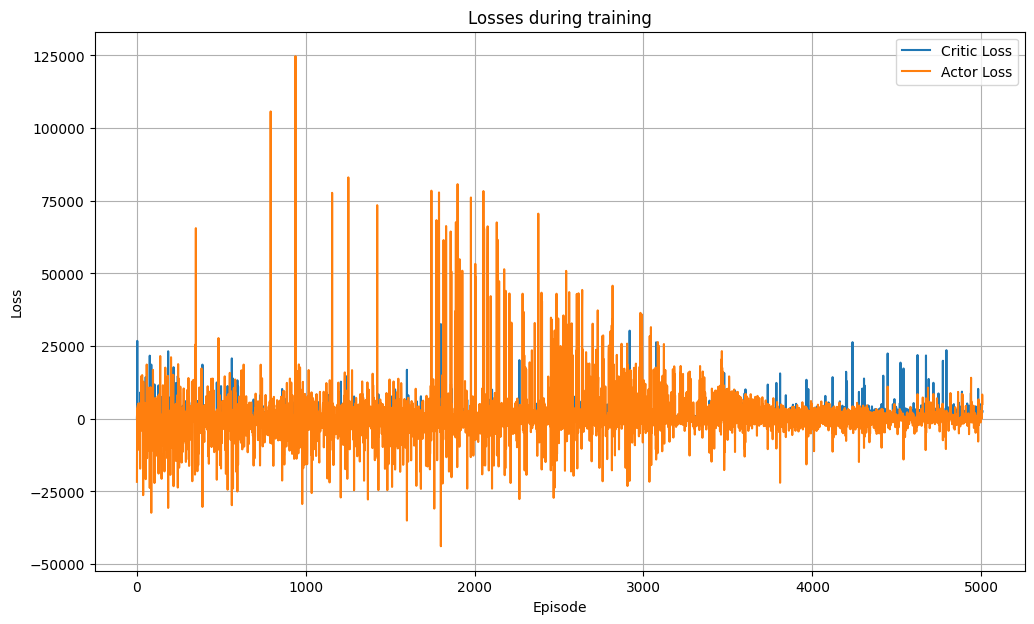

In [81]:
plt.figure(figsize=(12, 7))
plt.plot(c, label="Critic Loss")
plt.plot(a, label="Actor Loss")
plt.legend()
plt.title("Losses during training")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid()
plt.savefig("losses.png")